In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import graph_tool.all as gt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import sklearn.discriminant_analysis
import sklearn.ensemble
import sklearn.gaussian_process
import sklearn.metrics as metrics
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.neural_network
import sklearn.svm
import sklearn.tree
from umap import UMAP

from functions import *


# Style
sns.set_theme(context='paper', style='white', palette='Set2')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Parameters

In [3]:
col = 'SCZ'
batch_size = 32
seed = 42

## Script
# cols = [
#     'PD', 'PD_uncertain_plus_encephalitic', 'DLBD', 'FTD',
#     'ALS', 'Others_Neurodegenerative', 'MS', 'PSP', 'Epilepsy', 'Seizures',
#     'Tumor', 'Migraine_headaches', 'Head_Injury', 'Vascular', 'Others_Neurological',
#     'SCZ', 'MDD', 'BD_unspecific', 'BD_I', 'BD_II', 'PTSD', 'ADHD',
#     'OCD', 'Tardive_Dyskinesia_Neuroleptic_induced', 'Schizoaffective_bipolar',
#     'Schizoaffective_depressive', 'Anorexia', 'Bulimia', 'Anxiety',
#     'Binge_Purge', 'Eating_disorder', 'Others_Neuropsychiatric',
#     'Diabetes_mellitus_unspecified', 'TD_I', 'TD_II',
# ]  # Columns to analyze (HBCC)
# for col in cols:
#     print()
#     print(col)

# Data

In [4]:
# Get data
meta = get_meta()
graph_embeddings = load_graph_embeddings()

# Format embeddings
labels = []
embeddings = []
for k, v in graph_embeddings.items():
    labels.append(k)
    embeddings.append(v)
embeddings = np.stack(embeddings, axis=0)

# Convert to torch data
embeds = torch.tensor(embeddings)
classes = [meta.loc[meta['SubID']==sid][col].item() for sid in labels]
classes = torch.tensor(classes).long()

# Skip if any other than two classes
unq, cnt = classes.unique(return_counts=True)
print(f'Unique values {list(unq.numpy())} with counts {list(cnt.numpy())}')
if unq.shape[0] != 2 or cnt.min() < 5:  # 5 is arbitrary here and based on .8
    print(f'Insufficient data, skipping.')
    ## Script
    # continue

Unique values [0, 1] with counts [250, 50]


# Train Model

In [5]:
## Model initialization
# Initialize
np.random.seed(seed)
torch.manual_seed(seed)

# Create model
class Model(torch.nn.Module):
    def __init__(self, input_dim=128, output_dim=2):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.BatchNorm1d(input_dim // 2),  # Disabling prevents overfitting
            nn.LeakyReLU(),
            nn.Dropout(.8),  # Disabling helps accuracy
            
            nn.Linear(input_dim // 2, output_dim),
            # nn.BatchNorm1d(output_dim),
        )
        
    def forward(self, X):
        return self.net(X)
    
model = Model(
    input_dim=embeds.shape[1],
    output_dim=classes.unique().shape[0],
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=1)
criterion = nn.CrossEntropyLoss()

## Training loop
# Split to train and test idx
train_idx = val_idx = 0
while np.unique(classes[train_idx]).shape[0] < 2 or np.unique(classes[val_idx]).shape[0] < 2:
    # Keep splitting until each of train and val have at least one sample
    train_idx = np.random.choice(embeds.shape[0], int(.7 * embeds.shape[0]), replace=False)  # .8
    val_idx = np.array(list(set(range(embeds.shape[0])) - set(train_idx)))

# Train
model.train()
for epoch in range(1001):
    for _ in range(len(train_idx) // batch_size):
        # Calculate loss
        batch_idx = np.random.choice(train_idx, batch_size, replace=False)
        logits = model(embeds[batch_idx])
        loss = criterion(logits, classes[batch_idx])
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
    
    if epoch % 100 == 0:
        # Calculate val loss
        model.eval()
        logits = model(embeds[val_idx])
        val_loss = criterion(logits, classes[val_idx])
        model.train()

        # CLI
        print(f'Epoch: {epoch:03} - Loss: {loss.item():.3f} - Val Loss: {val_loss.item():.3f}')
model.eval()

## Evaluation
# Calculate evaluation metrics
logits = model(embeds).detach()
preds = logits.argmax(dim=-1)
y_true = classes
for name, metric, y_pred in zip(
    ['BACC', 'AUROC', 'AUPRC'],
    [metrics.balanced_accuracy_score, metrics.roc_auc_score, metrics.average_precision_score],
    [preds, F.softmax(logits, dim=-1)[:, 1], F.softmax(logits, dim=-1)[:, 1]]
):
    train_metric = metric(y_true[train_idx], y_pred[train_idx])
    val_metric = metric(y_true[val_idx], y_pred[val_idx])
    print(f'{name} (train={train_metric:.3f}, val={val_metric:.3f})')

Epoch: 000 - Loss: 1.010 - Val Loss: 0.825
Epoch: 100 - Loss: 0.513 - Val Loss: 0.460
Epoch: 200 - Loss: 0.400 - Val Loss: 0.491
Epoch: 300 - Loss: 0.546 - Val Loss: 0.640
Epoch: 400 - Loss: 0.448 - Val Loss: 0.731
Epoch: 500 - Loss: 0.551 - Val Loss: 0.989
Epoch: 600 - Loss: 0.336 - Val Loss: 0.475
Epoch: 700 - Loss: 0.250 - Val Loss: 0.859
Epoch: 800 - Loss: 0.275 - Val Loss: 0.830
Epoch: 900 - Loss: 0.361 - Val Loss: 0.552
Epoch: 1000 - Loss: 0.187 - Val Loss: 1.136
BACC (train=0.500, val=0.500)
AUROC (train=0.895, val=0.616)
AUPRC (train=0.607, val=0.277)


In [6]:
# Format data
X_train, y_train = embeds[train_idx], classes[train_idx]
X_val, y_val = embeds[val_idx], classes[val_idx]

# Get classifier classes
classifiers = [
    sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(),
    sklearn.ensemble.RandomForestClassifier(random_state=seed),
    sklearn.ensemble.AdaBoostClassifier(random_state=seed),
    sklearn.gaussian_process.GaussianProcessClassifier(random_state=seed),
    sklearn.naive_bayes.GaussianNB(),
    sklearn.neighbors.KNeighborsClassifier(),
    sklearn.neural_network.MLPClassifier(random_state=seed),
    sklearn.svm.SVC(probability=True, random_state=seed),
    sklearn.tree.DecisionTreeClassifier(random_state=seed),
]

# Try all classifiers
from collections import defaultdict
metric_list = defaultdict(lambda: [])
for classifier in classifiers:
    classifier.fit(X_train, y_train)

    # Predict train
    y_true_train = y_train
    logits_train = classifier.predict_proba(X_train)
    y_pred_train = logits_train[:, np.argwhere(classifier.classes_ == 1).flatten()[0]]
    y_pred_train_disc = 1*(y_pred_train >= .5)

    # Predict test
    y_true = y_val
    logits = classifier.predict_proba(X_val)
    y_pred = logits[:, np.argwhere(classifier.classes_ == 1).flatten()[0]]
    y_pred_disc = 1*(y_pred >= .5)

    # Metrics
    bacc_train = metrics.balanced_accuracy_score(y_true_train, y_pred_train_disc)
    auroc_train = metrics.roc_auc_score(y_true_train, y_pred_train)
    auprc_train = metrics.average_precision_score(y_true_train, y_pred_train)
    bacc = metrics.balanced_accuracy_score(y_true, y_pred_disc)
    auroc = metrics.roc_auc_score(y_true, y_pred)
    auprc = metrics.average_precision_score(y_true, y_pred)

    # Record and CLI
    metric_list['bacc_train'].append(bacc_train)
    metric_list['auroc_train'].append(auroc_train)
    metric_list['auprc_train'].append(auprc_train)
    metric_list['bacc'].append(bacc)
    metric_list['auroc'].append(auroc)
    metric_list['auprc'].append(auprc)
    print(f'{str(classifier):>45}: BACC: {bacc_train:.3f} ({bacc:.3f}), AUROC: {auroc_train:.3f} ({auroc:.3f}), AUPRC: {auprc_train:.3f} ({auprc:.3f})')

# Rank order by AUROC
print(f'AUROC Rank: {", ".join([str(classifiers[i]).split("(")[0] for i in np.argsort(metric_list["auroc"])[::-1]])}')

              QuadraticDiscriminantAnalysis(): BACC: 0.588 (0.500), AUROC: 1.000 (0.500), AUPRC: 1.000 (0.178)


/home/noahcohenkalafut/miniconda3/envs/gnn/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


      RandomForestClassifier(random_state=42): BACC: 1.000 (0.473), AUROC: 1.000 (0.422), AUPRC: 1.000 (0.177)
          AdaBoostClassifier(random_state=42): BACC: 1.000 (0.535), AUROC: 1.000 (0.531), AUPRC: 1.000 (0.221)


/home/noahcohenkalafut/miniconda3/envs/gnn/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


   GaussianProcessClassifier(random_state=42): BACC: 0.515 (0.500), AUROC: 0.630 (0.438), AUPRC: 0.295 (0.156)
                                 GaussianNB(): BACC: 0.559 (0.372), AUROC: 0.582 (0.425), AUPRC: 0.222 (0.152)
                       KNeighborsClassifier(): BACC: 0.533 (0.486), AUROC: 0.769 (0.478), AUPRC: 0.305 (0.175)
               MLPClassifier(random_state=42): BACC: 0.500 (0.500), AUROC: 0.462 (0.539), AUPRC: 0.175 (0.201)
       SVC(probability=True, random_state=42): BACC: 0.500 (0.500), AUROC: 0.622 (0.576), AUPRC: 0.373 (0.338)
      DecisionTreeClassifier(random_state=42): BACC: 1.000 (0.470), AUROC: 1.000 (0.470), AUPRC: 1.000 (0.173)
AUROC Rank: SVC, MLPClassifier, AdaBoostClassifier, QuadraticDiscriminantAnalysis, KNeighborsClassifier, DecisionTreeClassifier, GaussianProcessClassifier, GaussianNB, RandomForestClassifier


In [7]:
# Final exports
logits = model(embeds).detach()
y_true = classes[val_idx]
y_pred = F.softmax(logits, dim=-1)[:, 1][val_idx]
y_pred_disc = y_pred >= .5

## Plot

Text(0.5, 1.0, 'HBCC SCZ Precision-Recall Curve')

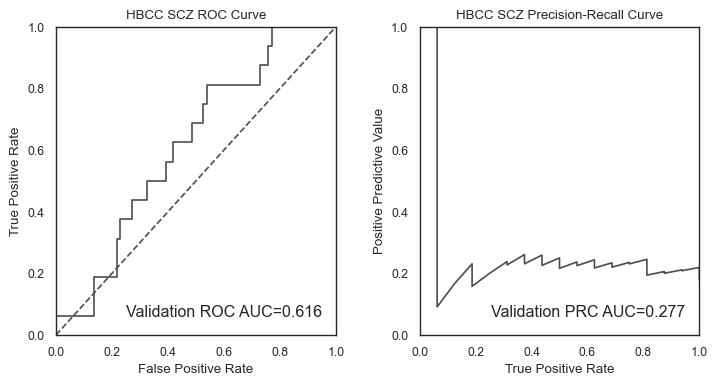

In [8]:
# Create figure
num_subplots = 2; wspace = .3; infigsize = 4
fig, axs = plt.subplots(1, num_subplots, figsize=(infigsize*num_subplots+wspace*(num_subplots-1), infigsize))
fig.subplots_adjust(wspace=wspace)

# UMAP
# ax = axs[0]
# umap = UMAP(
#     n_components=2,
#     n_neighbors=60,  # 15
#     min_dist=.5,  # .1
#     metric='euclidean',
#     random_state=42,
# ).fit_transform(embeddings)
# # Get colors
# color_index = np.array([str(v) for v in pd.unique(meta[col])])
# color = []
# for sid in labels:
#     val = str(meta.loc[meta['SubID']==sid][col].item())
#     color.append(val)
# color = np.array(color)
# # Plot
# for c in np.unique(color):
#     if float(c) == 1: label = col
#     elif float(c) == 0: label = 'Control'
#     else: label = 'NA'
#     ax.scatter(*umap[color==c].T, label=label)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xlabel('UMAP-1')
# ax.set_ylabel('UMAP-2')
# # Legend
# legend_handles, legend_labels = ax.get_legend_handles_labels()
# ax.legend(legend_handles[::-1], legend_labels[::-1])

# Compute metrics
fpr, tpr, roc_thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.roc_auc_score(y_true, y_pred)
precision, recall, prc_thresholds = metrics.precision_recall_curve(y_true, y_pred)
prc_auc = metrics.average_precision_score(y_true, y_pred)

# ROC Curve
ax = axs[0]
ax.plot(fpr, tpr, color='.3')
ax.plot([0, 1], [0, 1], color='.3', linestyle='--')
ax.text(.95, .05, f'Validation ROC AUC={roc_auc:.3f}', ha='right', va='bottom', fontsize='large')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'HBCC SCZ ROC Curve')

# PRC
ax = axs[1]
ax.plot(recall, precision, color='.3')
ax.text(.95, .05, f'Validation PRC AUC={prc_auc:.3f}', ha='right', va='bottom', fontsize='large')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('True Positive Rate')
ax.set_ylabel('Positive Predictive Value')
ax.set_title('HBCC SCZ Precision-Recall Curve')

# Save
# fig.savefig(f'../plots/HBCC_performance_{col}.pdf', format='pdf', transparent=True, bbox_inches='tight')